In [146]:
from ipywidgets import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
style = {'description_width': 'initial'}
layout = Layout(width = '400px')
models = [None] * 4 

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected = True)

## Реалізація МНКО

In [150]:
def RMNK(X, y, s=None, verbose=False, deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, verbose,
                                     deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, verbose, deep_verbose,
                                 create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,
                                           (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        Cp = RSS_next + 2 * m
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        df = df.append({'s': m, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},
                       ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

## 1. Модель Фергюльста

### Рівняння моделі
### $N'=μN(k-N) \enspace | \enspace N_0$ 

### Різницеве рівняння
### $\Delta t = 1$
### $N'(t)≈ N(t+1)-N(t) \enspace - \enspace різниця\:вперед$
### $N'(t)≈ N(t)-N(t-1) \enspace - \enspace різниця\:назад$
### $N'(t)≈ \frac{N(t+1)-N(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $Розглядатимемо\: для\: різниці\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}N(t+1)-N(t)=μN(t)[k-N(t)] \\ N(0) = N_0\end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}N(t+1)=(μk+1)N(t)-μN^2(t) \\ N(0) = N_0\end{array} \right. $
### $y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i, \enspace \enspace θ_1 = μk+1; \enspace θ_2 = -μ; \enspace Eξ = 0_n; \enspace cov(ξ) = σ^2I_n$
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = μk+1\\
                  θ_2 = -μ\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
### $ \Rightarrow \left \{ \begin{array}{ll}
                  μ = -θ_2 \\
                  k = (1 - θ_1) / θ_2
                \end{array}
              \right. $

Initial parameters:	μ = 0.0001
			               k = 100
			N0 = 10

Noise generation: C = 3
Sample length: n = 50
Time starting from 0 to 500                with discretization frequency 10



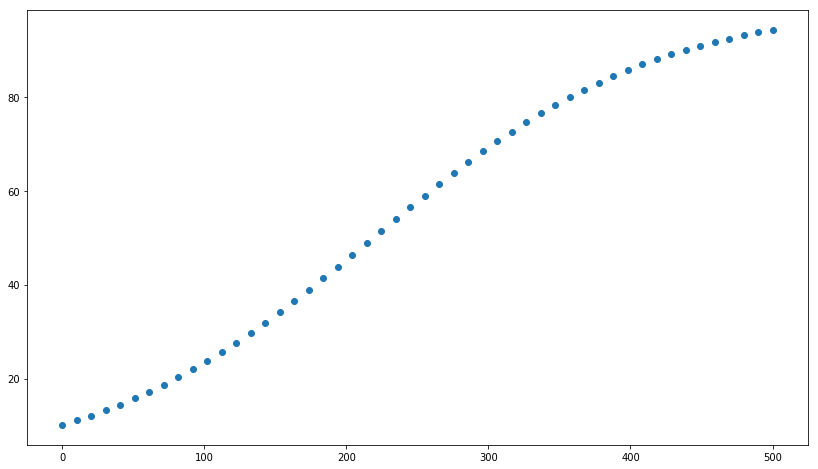

Intermediate parameters values: θ_1 = 1.01	θ_2 = -0.0001
Regression model: y = (1.01) * x1 + (-0.0001) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.000000,100.000000,10.090
1,2,10,10.956582,120.046684,11.054
2,3,20,11.992475,143.819461,12.098
3,4,30,13.111886,171.921546,13.226
4,5,40,14.318785,205.027597,14.441
5,6,51,15.616808,243.884680,15.749
6,7,61,17.009139,289.310822,17.150
7,8,71,18.498393,342.190549,18.649
8,9,81,20.086481,403.466709,20.247
9,10,91,21.774481,474.128027,21.945


In [162]:
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)

class VerhulstModelConfig(): 
    k = 100
    μ = 0.0001
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation, self.N0, self.t, (self.μ, self.k))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\t\
               k = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        w1 = self.μ * self.k + 1
        w2 = -self.μ
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['N(t)'] = self.N.flatten()
        self.df['N^2(t)'] = np.square(self.N.flatten())
        self.df['N(t+1)'] = np.array(self.df[['N(t)','N^2(t)']]) @ self.theta
        self.df['N(t+1)'] = np.round(self.df['N(t+1)'], self.C)
        self.X = np.array(self.df[['N(t)', 'N^2(t)']])
        self.y = np.array(self.df['N(t+1)'])
        
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['N(t)'],
            y=self.df['N^2(t)'],
            z=self.df['N(t+1)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')
    
config = VerhulstModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

In [163]:
config.plot_3D()

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		192021.11695382808
alpha_1:	[0]
beta_1:		192021.11695382808
gamma_1:	192454.57239914758
nu_1:		[1.00225733]
> θ_1: [1.00225733]
> H_1_inv:
[[5.20776056e-06]]
> RSS_1: 0.5984206103312317
	Step 2
h_2:		[14865979.31260227]
eta_2:		1210738873.994198
alpha_2:	[77.41846078]
beta_2:		[[59837637.56477976]]
gamma_2:	14893552.79759949
nu_2:		[[-0.0001]]
> θ_2: [ 1.00999944e+00 -1.00003420e-04]
> H_2_inv:
[[ 1.05372445e-04 -1.29380878e-06]
 [-1.29380878e-06  1.67118897e-08]]
> RSS_2: 3.3057016820547958e-06

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.01	θ_2 = -0.0001
Estimates:	θ_1* = 1.0099994430189054	θ_2* = -0.00010000341994466655

INITIAL PARAMETERS
True values:	μ = 0.0001	k = 100
Estimates:	μ* = 0.00010000341994466655	k* = 99.9910105518219


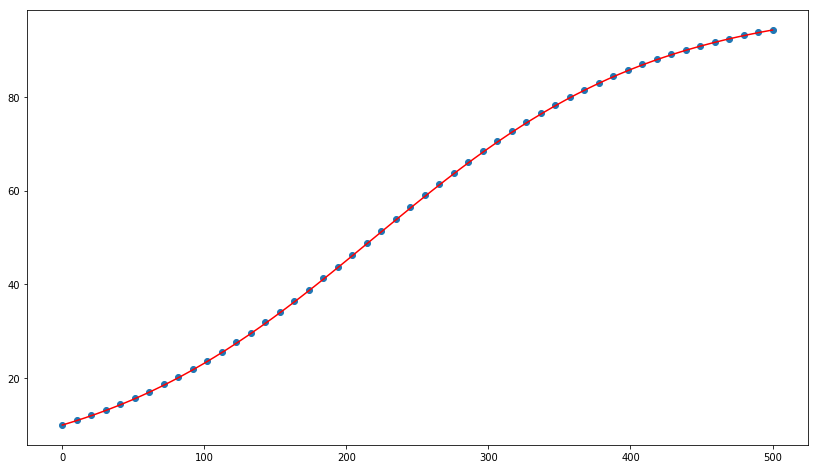

In [157]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tμ = {}\tk = {}'.format(config.μ, config.k))
print('Estimates:\tμ* = {}\tk* = {}'.format(μ_pred, k_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end,
                         num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Verhulst_model_equation, config.N0, t_for_plot,
                            (μ_pred, k_pred)), 'r')
plt.show()

In [158]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                  'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'μ*', 'k*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C,
                                          'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0],
                                          'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C,
                                     'num_samples': config.num_samples,
                                     'μ*': μ_pred, 'k*': k_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C,
                                                   config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tμ* = {: 12.8}\tk* = {: 12.8}'.format(μ_pred, k_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tμ = {}\tk = {}'.format(config.μ, float(config.k)))
pd.concat([intermediate_estimates_df,
           initial_estimates_df[['μ*', 'k*']]], axis=1)

True inter. params values:	θ_1 = 1.01	θ_2 = -0.0001
True init.  params values:	μ = 0.0001	k = 100.0


,C,num_samples,θ_1*,θ_2*,μ*,k*
0,0.0,10.0,0.998957,0.000044,-0.000044,23.826999
1,0.0,50.0,1.010265,-0.000106,0.000106,96.768521
2,0.0,100.0,1.009688,-0.000097,0.000097,100.083587
3,2.0,10.0,1.009857,-0.000098,0.000098,100.559471
4,2.0,50.0,1.009994,-0.000100,0.000100,100.105598
5,2.0,100.0,1.009956,-0.000099,0.000099,100.113571
6,5.0,10.0,1.010000,-0.000100,0.000100,100.000233
7,5.0,50.0,1.010000,-0.000100,0.000100,100.000141
8,5.0,100.0,1.010000,-0.000100,0.000100,100.000091


---

## 2. Рівняння вимушених коливань

### Модель рівняння
### $x''+2δ x'+ω_0^2 x=0$

### Різницеве рівняння
### $\Delta t = 1$
### $x'(t)≈ x(t+1)-x(t) \enspace - \enspace різниця\:вперед$
### $x'(t)≈ x(t)-x(t-1) \enspace - \enspace різниця\:назад$
### $x'(t)≈ \frac{x(t+1)-x(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $x''(t)≈ x(t+1)-2x(t)+x(t-1)$
### $Розглянемо\: для\: апроксимації\: різницею\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+2δ[x(t+1)-x(t)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2+2δ-ω_0^2}{1+2δ}x(t+1)-\frac{1}{1+2δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2+2δ-ω_0^2}{1+2δ}\\
                  θ_2 = -\frac{1}{1+2δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500                with discretization frequency 6



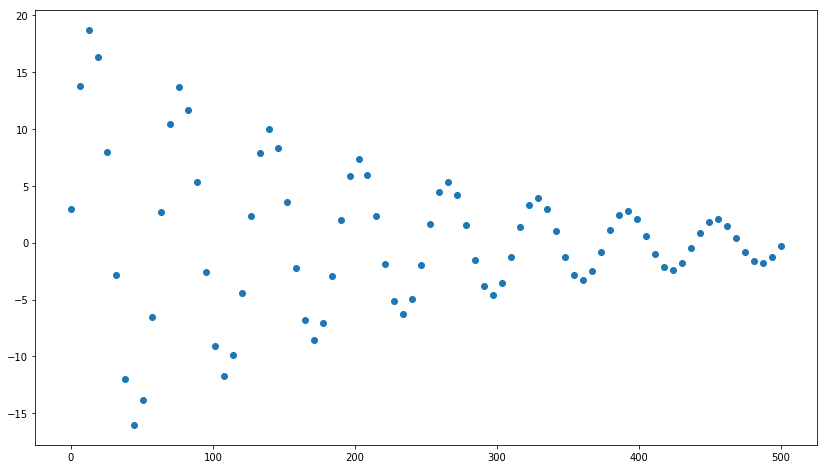

Intermediate parameters values: θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Regression model: y = (1.98019801980198) * x1 + (-0.9900990099009901) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [168]:
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]        

class OscillationModelConfig(): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation,
                        np.array([self.x0, self.x00]),
                        self.t, (self.δ, self.ω0_sqr))
        self.x1 = self.x0 + self.x00
        self.x11 = self.x00
        self.x_1 = odeint(Oscillation_model_equation,
                          np.array([self.x1, self.x11]), self.t+1,
                          (self.δ, self.ω0_sqr))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0^2 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0_sqr,
                                                        self.x0, self.x00))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        divider = 1 + 2 * self.δ
        w1 = (2 + 2 * self.δ - self.ω0_sqr) / divider
        w2 = - 1 / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = - (1 / w2 + 1) / 2
        ω0_sqr = 1 - 1 / w2 + w1 / w2
        return δ, ω0_sqr
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['x(t)'] = self.x[:,0].flatten()
        self.df['x(t+1)'] = self.x_1[:,0].flatten()
        self.df['x(t+2)'] = np.array(self.df[['x(t)','x(t+1)']]) @ self.theta
        self.df['x(t+2)'] = np.round(self.df['x(t+2)'], self.C)
        self.X = np.array(self.df[['x(t)', 'x(t+1)']])
        self.y = np.array(self.df['x(t+2)'])
    
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['x(t)'],
            y=self.df['x(t+1)'],
            z=self.df['x(t+2)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')
        
config = OscillationModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

In [169]:
config.plot_3D()

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.3120437748094
nu_1:		[0.95802084]
> θ_1: [0.95802084]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.453858680093163
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.2987274811694
nu_2:		[[-0.99045368]]
> θ_2: [ 1.98062616 -0.99045368]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006414646992354278

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Estimates:	θ_1* = 1.9806261560117218	θ_2* = -0.9904536768605774

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.004819166894145632	ω0^2* = 0.009922241775108143


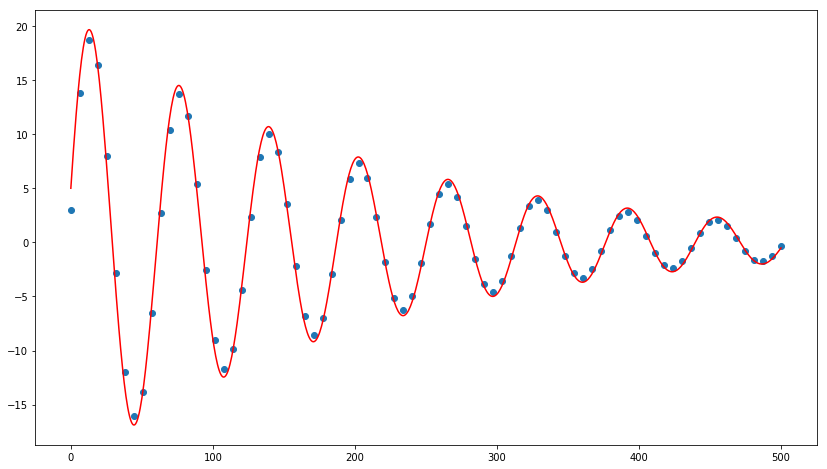

In [142]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\t\t\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end,
                         num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation, np.array([config.x0,
                                                                  config.x00]),
                         t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [95]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                  'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                             'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C,
                                          'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0],
                                          'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C,
                                     'num_samples': config.num_samples,
                                     'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred,
                                                                    ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\t\t\tω0^2 = {}'.format(config.δ,
                                                                 config.ω0_sqr))
pd.concat([intermediate_estimates_df,
           initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
True init.  params values:	δ = 0.005			ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.045579,0.006809
1,0.0,80.0,1.959643,-0.966105,0.017542,0.006689
2,0.0,150.0,1.985392,-0.991847,0.004110,0.006507
3,2.0,30.0,1.980402,-0.990257,0.004919,0.009952
4,2.0,80.0,1.980626,-0.990454,0.004819,0.009922
5,2.0,150.0,1.980007,-0.989910,0.005096,0.010005
6,5.0,30.0,1.980197,-0.990098,0.005001,0.010000
7,5.0,80.0,1.980199,-0.990100,0.005000,0.010000
8,5.0,150.0,1.980197,-0.990098,0.005000,0.010000


### $Розглянемо\: для\: апроксимації\: центральною\: різницею:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+δ[x(t+1)-x(t-1)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2-ω_0^2}{1+δ}x(t+1)-\frac{1-δ}{1+δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2-ω_0^2}{1+δ}\\
                  θ_2 = -\frac{1-δ}{1+δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500                with discretization frequency 6



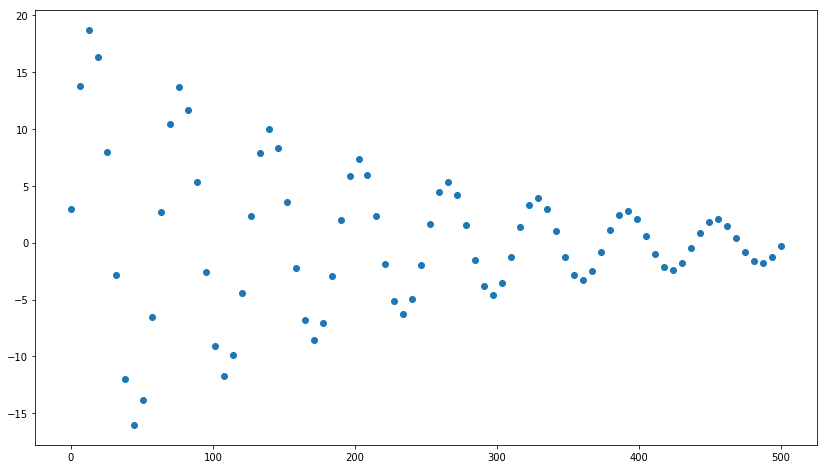

Intermediate parameters values: θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Regression model: y = (1.9800995024875623) * x1 + (-0.9900497512437811) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [96]:
class OscillationModelConfig_center(OscillationModelConfig): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def init_to_inter_params(self):
        divider = 1 + self.δ
        w1 = (2 - self.ω0_sqr) / divider
        w2 = - (1 - self.δ) / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = (1 + w2) / (1 - w2)
        ω0_sqr = (2 - 2 * w1 - 2 * w2) / (1 - w2)
        return δ, ω0_sqr
        
config = OscillationModelConfig_center()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.2782321079894
nu_1:		[0.95801117]
> θ_1: [0.95801117]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.447942916061493
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.2668093266866
nu_2:		[[-0.99035405]]
> θ_2: [ 1.98051363 -0.99035405]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006504761413275162

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.9805136264573653	θ_2* = -0.9903540525860844

INITIAL PARAMETERS
True values:	δ = 0.005	ω0^2 = 0.01
Estimates:	δ* = 0.004846347513590607	ω0^2* = 0.00988811625342075


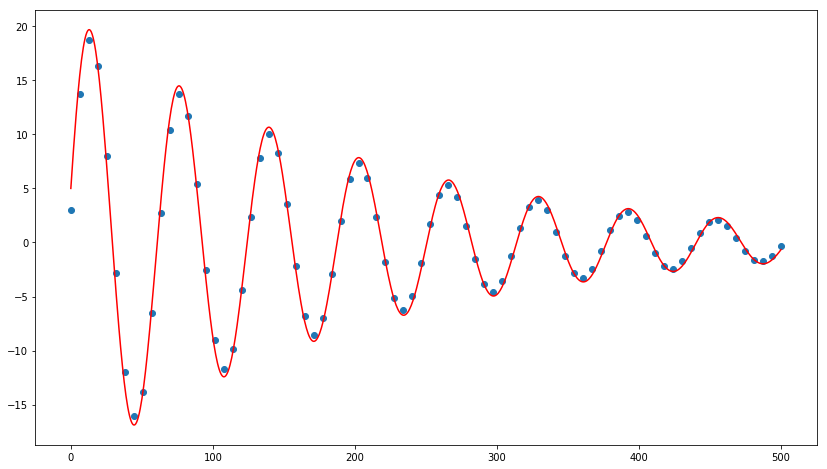

In [97]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('===============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation,
                            np.array([config.x0, config.x00]),
                            t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [98]:
center_intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                         'θ_1*', 'θ_2*'])
center_initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                    'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        center_intermediate_estimates_df = \
        center_intermediate_estimates_df.append({'C': config.C,
                                                 'num_samples': config.num_samples,
                                                 'θ_1*': theta_pred[0],
                                                 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        center_initial_estimates_df = \
        center_initial_estimates_df.append({'C': config.C,
                                            'num_samples': config.num_samples,
                                            'δ*': δ_pred,
                                            'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred,
                                                                    ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\tω0^2 = {}'.format(config.δ, 
                                                             config.ω0_sqr))
pd.concat([center_intermediate_estimates_df,
           center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
True init.  params values:	δ = 0.005	ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888
5,2.0,150.0,1.979936,-0.989861,0.005095,0.009975
6,5.0,30.0,1.980099,-0.990050,0.005000,0.010000
7,5.0,80.0,1.980099,-0.990050,0.005000,0.010000
8,5.0,150.0,1.980100,-0.990050,0.005000,0.010000


In [99]:
center_df = pd.concat([center_intermediate_estimates_df,
                       center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
center_df['difference'] = 'center'
forward_df = pd.concat([intermediate_estimates_df,
                        initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
forward_df['difference'] = 'forward'
pd.concat([center_df, forward_df], axis=0).sort_values(by=['C',
                                                           'num_samples',
                                                           'difference'])

,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*,difference
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134,center
0,0.0,30.0,2.092809,-1.100300,-0.045579,0.006809,forward
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574,center
1,0.0,80.0,1.959643,-0.966105,0.017542,0.006689,forward
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481,center
2,0.0,150.0,1.985392,-0.991847,0.004110,0.006507,forward
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935,center
3,2.0,30.0,1.980402,-0.990257,0.004919,0.009952,forward
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888,center
4,2.0,80.0,1.980626,-0.990454,0.004819,0.009922,forward


## 3. Дослідження закономірностей задачі структурно параметричної ідентифікації 

### $RSS(s)$
### $C_p(s) = RSS(s) + 2s$
### $FPE(s) = \frac{n + s}{n - s} RSS(s)$

In [143]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 0.01
    sigma_grid = [0.1, 0.5, 1]
    s = 5
    s_grid = [1, 2, 3, 4, 5]
    
    def __init__(self):
        self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self):
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def recompile(self, n, sigma):
        self.n = n
        self.sigma = sigma
        self.compile()
        
    def show(self):
#         print('Regressors: m = {}'.format(self.m))
#         print('True parameters: θ = {}'.format(self.theta))
        print('Sample length: n = {}'.format(self.n))
        print('Noise generation: σ = {}'.format(self.sigma))
        print('X[:10]:\n{}'.format(self.X[:10]))
        print('y[:10]:\n{}'.format(self.y[:10]))
        
config = ModelConfig()

In [144]:
config.generate_noise_and_output()
config.show()

Sample length: n = 10
Noise generation: σ = 0.01
X[:10]:
[[0.46165473 0.16675328 0.03271525 0.37664932 1.94683526]
 [0.88027703 1.9299957  1.92549131 1.32331778 0.48440871]
 [1.08812461 1.88254699 1.23759911 1.45297244 0.97884446]
 [0.64781664 1.81542015 1.67567277 0.87749025 1.65783845]
 [0.09415036 0.36604436 0.92446839 0.72910428 0.28618065]
 [0.90605499 0.99507968 0.3610597  1.85720223 0.65035522]
 [1.8043952  0.38961091 1.83225879 0.90365366 0.16862335]
 [1.33944884 1.66226047 1.58034281 1.07015155 1.08025488]
 [1.4472995  1.51378278 1.09359189 1.59798492 0.54375952]
 [1.31789415 0.10800125 1.48119851 0.4158724  0.24986585]]
y[:10]:
[ 1.07126286  0.69857453  0.73550007 -0.01115434  0.49721827  1.09480841
  6.46996364  2.28265308  2.41145972  5.22226129]


--------------------------------------------------------------
			SAMPLE #1
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.1
X[:10]:
[[0.2296353  0.01516823 1.17563599 0.24322971 0.32082644]
 [1.3364991  1.99829207 0.08757905 0.17062012 1.24143043]
 [1.87036675 0.28039567 1.94452821 0.20479922 0.25424814]
 [1.17963777 1.56838237 1.33761683 0.29497259 0.51813073]
 [0.9804581  0.93992359 1.35432719 1.13164677 0.18081592]
 [1.51099502 0.25426335 0.87576588 0.25297059 0.54661157]
 [1.17523963 0.3561381  1.23743794 1.05395347 0.89451171]
 [1.22755112 1.17249965 0.8945771  1.97236222 1.52479736]
 [0.60676339 1.26264846 0.63480085 0.6367021  1.69187617]
 [0.27587952 0.23795241 1.98053972 0.11544165 0.16795807]]
y[:10]:
[ 1.72240075  0.32687258  6.95744687  1.66782861  2.4942128   4.99420022
  3.95392689  2.0583462  -0.16471555  2.20931677]

		RLSM ITERATIONS
	Step 1
> θ_1: [2.51681781]
> H_1_inv:
[[0.0751567

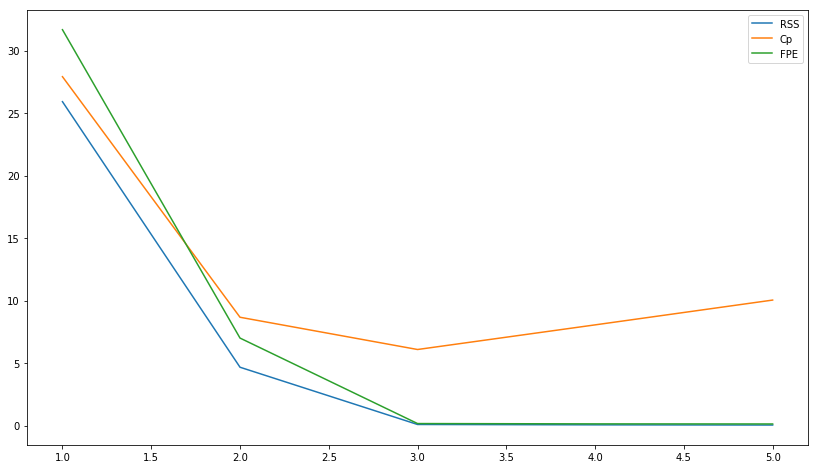

     s        RSS         Cp        FPE
0  1.0  25.920760  27.920760  31.680929
1  2.0   4.668034   8.668034   7.002051
2  3.0   0.086614   6.086614   0.160855
3  4.0   0.057743   8.057743   0.134733
4  5.0   0.042461  10.042461   0.127384
s* by Cp:  3
s* by FPE: 5

--------------------------------------------------------------
			SAMPLE #2
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.5
X[:10]:
[[1.63119411 1.33425717 1.86134234 1.85915519 1.77263397]
 [0.8478101  0.63020783 0.01367229 0.57588645 0.41189698]
 [1.25428491 1.17672512 0.94422172 1.97851781 0.2074109 ]
 [1.01263235 0.78199234 0.38805419 1.63954426 0.92144576]
 [0.51898411 1.00917736 0.37273389 1.30110459 1.45524114]
 [0.06756371 0.70629321 1.66184771 0.21431694 1.58117928]
 [0.0691786  1.22942848 1.21937224 1.38122111 0.47820347]
 [0.93822428 1.10898457 0.21917323 1.40432479 0.56025561]
 [1.53492557 0.60883055 0.64600309 1.50168772 0.98

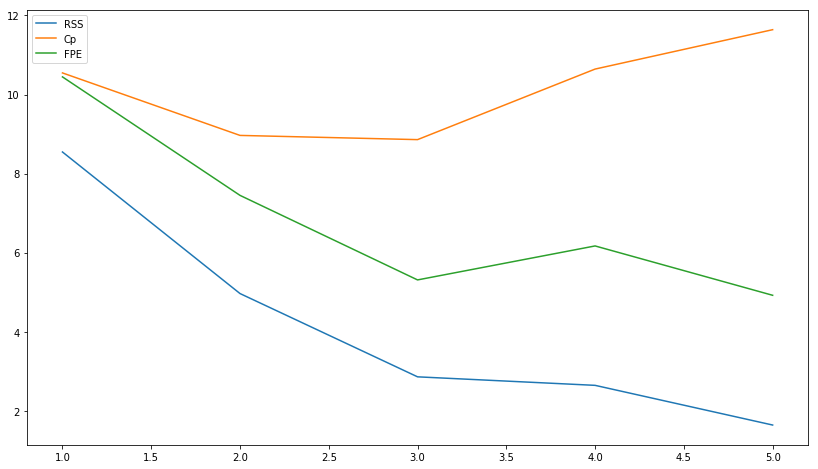

     s       RSS         Cp        FPE
0  1.0  8.547560  10.547560  10.447018
1  2.0  4.966709   8.966709   7.450064
2  3.0  2.860064   8.860064   5.311547
3  4.0  2.644670  10.644670   6.170898
4  5.0  1.640897  11.640897   4.922690
s* by Cp:  3
s* by FPE: 5

--------------------------------------------------------------
			SAMPLE #3
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 1
X[:10]:
[[1.95803307 0.01062239 0.90756382 1.24667568 1.43174446]
 [1.29213151 0.37799479 1.19175577 0.23298291 1.89617369]
 [0.73793737 0.69975265 1.81076468 0.44297207 0.99932281]
 [0.23961341 1.37655895 0.3637885  0.94645116 1.78743521]
 [0.6115152  1.60620977 1.31095685 0.10269311 1.21641361]
 [0.1278828  0.63525948 1.86929025 0.60665467 1.13614924]
 [0.01479508 1.46922887 0.56076225 0.97308527 1.63229167]
 [1.59539331 1.17436457 0.4970079  1.07249635 0.3410422 ]
 [0.31807903 1.84960804 1.29864069 1.47902531 1.9325135 ]


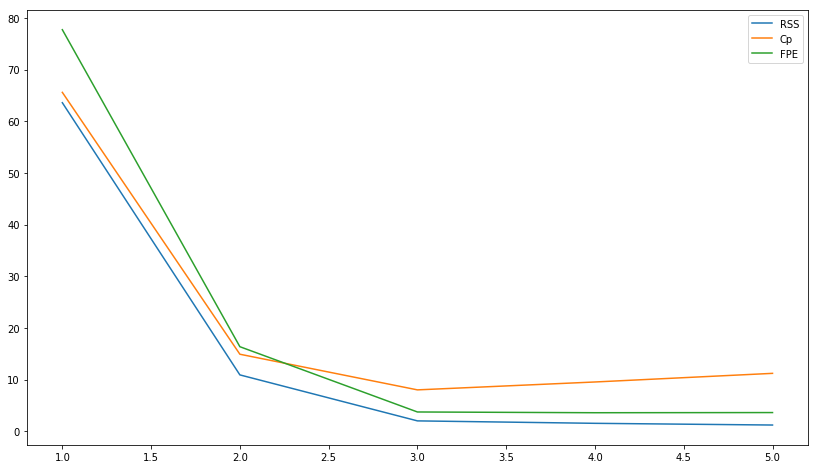

     s        RSS         Cp        FPE
0  1.0  63.578270  65.578270  77.706774
1  2.0  10.907916  14.907916  16.361874
2  3.0   2.009880   8.009880   3.732634
3  4.0   1.537549   9.537549   3.587615
4  5.0   1.206577  11.206577   3.619731
s* by Cp:  3
s* by FPE: 4

--------------------------------------------------------------
			SAMPLE #4
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.1
X[:10]:
[[1.86997833 0.06365282 1.55571686 0.24476152 1.52876104]
 [1.08141618 0.81242179 1.83022638 1.29096076 0.36082933]
 [0.29034908 0.60595728 1.84017174 1.92205508 0.93362099]
 [0.67853562 0.52069112 0.95644199 0.45015016 0.62954655]
 [1.35646064 1.81243701 1.54680813 1.00370147 0.45839624]
 [0.16731724 1.15942489 0.67319509 0.83889721 0.94205963]
 [1.74553471 1.46638109 1.2860637  1.03273299 0.30626343]
 [1.51856334 0.58308668 0.66744523 0.80491475 0.18753983]
 [0.11484563 0.63449662 1.19933673 1.8550969  1.48

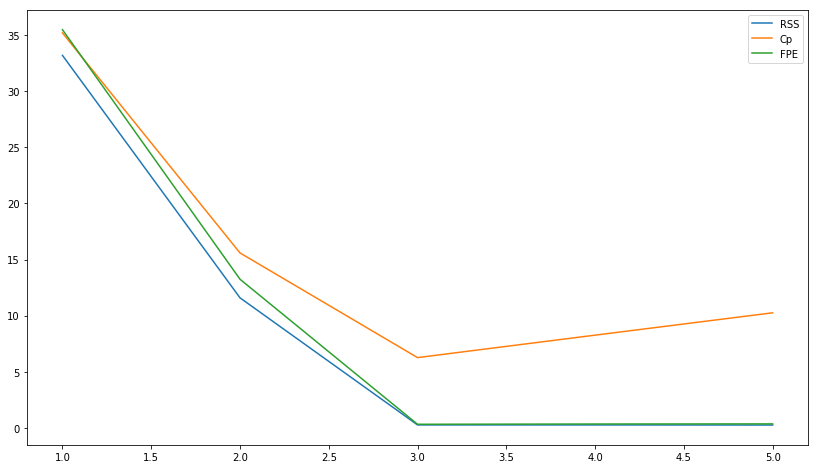

     s        RSS         Cp        FPE
0  1.0  33.194470  35.194470  35.483744
1  2.0  11.590295  15.590295  13.246051
2  3.0   0.264711   6.264711   0.323535
3  4.0   0.264611   8.264611   0.346030
4  5.0   0.255612  10.255612   0.357857
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #5
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.5
X[:10]:
[[1.97622672 0.93596546 1.7735628  1.59751281 1.82998272]
 [1.51182202 1.28715788 1.08086657 0.40820481 0.13288796]
 [1.37407853 1.24847603 1.23707    1.3009688  0.56833503]
 [1.81689814 1.1558884  0.75046906 1.83091512 1.49418192]
 [1.73789734 0.57128057 1.83734131 1.62479357 1.02086652]
 [0.35807234 1.75463795 1.08581799 1.36891528 1.22676091]
 [0.44133382 1.26216923 1.10737743 0.94264096 1.43164708]
 [0.38981706 0.93809775 1.78927067 1.48979492 0.30993968]
 [1.49878731 0.8394421  1.22203773 0.66346489 1.25

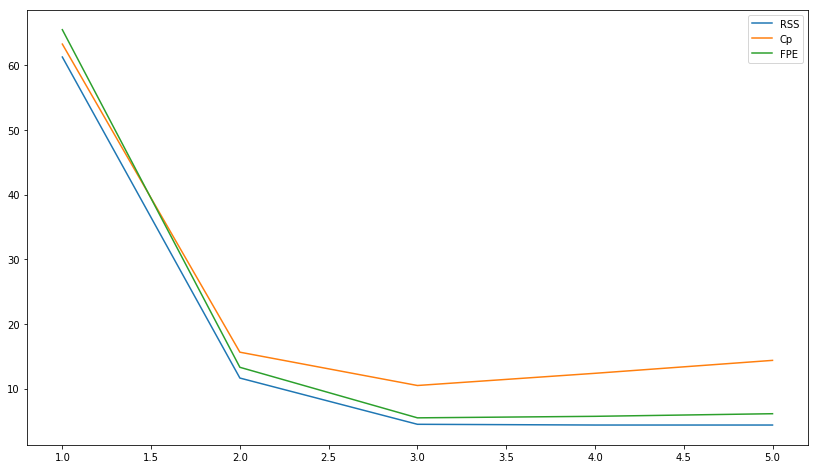

     s        RSS         Cp        FPE
0  1.0  61.292925  63.292925  65.520023
1  2.0  11.642845  15.642845  13.306108
2  3.0   4.490207  10.490207   5.488030
3  4.0   4.376036  12.376036   5.722509
4  5.0   4.375902  14.375902   6.126263
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #6
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 1
X[:10]:
[[1.02754752 1.03501303 1.16377167 0.29462768 0.78313378]
 [0.94635659 0.21553177 1.70023744 1.04228013 1.42177181]
 [0.02625494 0.5928099  1.80822378 1.3855247  0.46210038]
 [0.51633402 1.44850846 0.01903685 0.099102   1.80950199]
 [0.47063401 0.68514623 1.69372714 1.81038411 1.47164709]
 [1.15895969 1.44152098 0.2568554  1.66019979 0.11853255]
 [1.52681579 0.5430385  0.48668227 0.69468567 1.24570856]
 [0.80200368 1.31940844 1.53420407 0.22159697 1.07082829]
 [0.40125711 0.22238016 0.17994277 0.61458472 0.4081

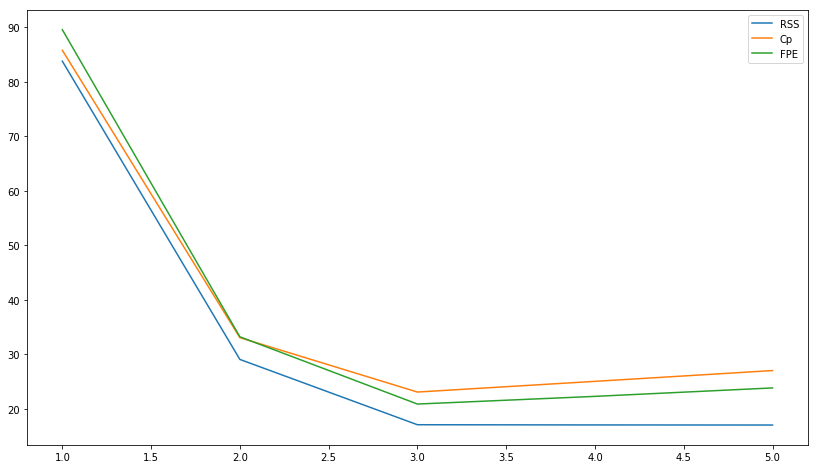

     s        RSS         Cp        FPE
0  1.0  83.816408  85.816408  89.596850
1  2.0  29.067322  33.067322  33.219797
2  3.0  17.079842  23.079842  20.875362
3  4.0  17.043311  25.043311  22.287407
4  5.0  17.024895  27.024895  23.834852
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #7
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.1
X[:10]:
[[0.62578323 0.70969087 1.54735853 1.45419469 0.76890801]
 [1.4643173  0.68745698 0.10095266 0.57078278 0.7234243 ]
 [0.49968149 1.34114567 1.00483933 1.98433684 0.56326664]
 [0.48149637 0.63108063 0.23183894 1.48088385 1.4598167 ]
 [0.89134899 1.19128486 0.56944378 0.67630828 1.78294454]
 [0.56498019 0.26763225 1.28657437 1.2443006  0.47245482]
 [1.51612024 1.27140434 0.89443173 1.43247032 0.28314901]
 [1.84804906 0.7620279  0.99371283 0.50197285 0.16970723]
 [0.07242719 1.22121413 0.21519658 1.55191862 1.0

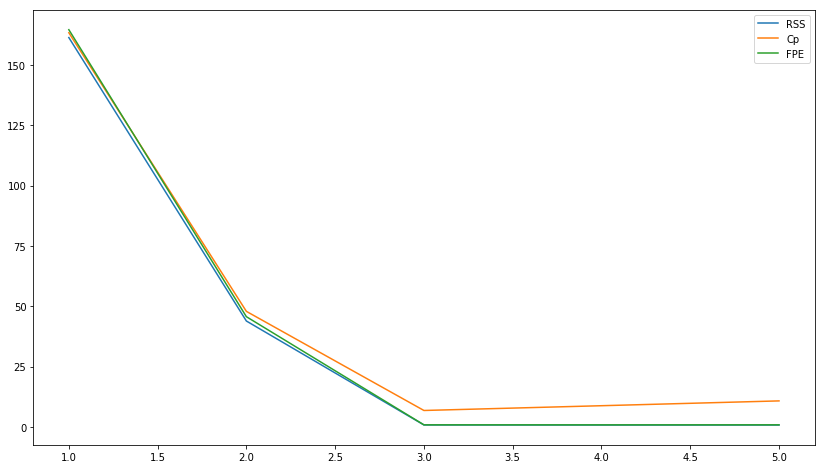

     s         RSS          Cp         FPE
0  1.0  161.351925  163.351925  164.611560
1  2.0   43.902842   47.902842   45.694795
2  3.0    0.834805    6.834805    0.886442
3  4.0    0.807652    8.807652    0.874956
4  5.0    0.803419   10.803419    0.887989
s* by Cp:  3
s* by FPE: 4

--------------------------------------------------------------
			SAMPLE #8
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.5
X[:10]:
[[0.27501189 0.54452718 0.07565737 0.01494198 0.33423812]
 [0.28643642 1.54087776 1.03486669 1.59001201 1.8397392 ]
 [1.64200769 1.81055477 1.8902723  1.84625188 1.8782924 ]
 [1.9481839  1.38732909 1.77978808 0.22906637 0.67995757]
 [1.6345354  0.00607977 1.29539967 1.27404005 0.69777551]
 [1.9435777  1.03693809 1.58944946 1.98334583 1.63319838]
 [1.56868407 0.12023442 0.27149534 0.17882734 0.63074092]
 [1.57370143 0.11130576 1.97556215 1.34881295 1.72864123]
 [1.52861499 0.1812905  1.15514

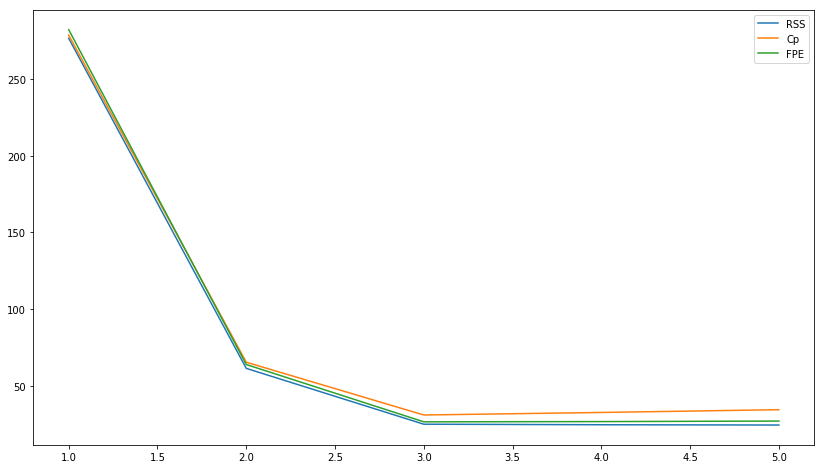

     s         RSS          Cp         FPE
0  1.0  276.543907  278.543907  282.130652
1  2.0   61.439556   65.439556   63.947293
2  3.0   25.050778   31.050778   26.600311
3  4.0   24.704819   32.704819   26.763554
4  5.0   24.512935   34.512935   27.093244
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #9
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 1
X[:10]:
[[0.7249198  0.22365328 1.64717287 1.98269609 1.4340498 ]
 [0.79189784 0.87316726 1.46143467 0.67456917 1.79909035]
 [0.19288402 0.90168592 1.82621198 0.85098253 1.57502212]
 [0.79750414 0.79809994 0.13615693 0.25048356 0.73389557]
 [1.8683615  1.02350984 0.97217844 0.18997645 0.62720823]
 [1.47684968 1.0937847  0.89563115 1.64894593 0.83923091]
 [0.77794726 1.6467119  1.26458127 1.61390831 0.17676981]
 [1.30450159 1.4776953  1.7480483  1.04660938 0.37542871]
 [1.01589227 1.61392555 0.7131441

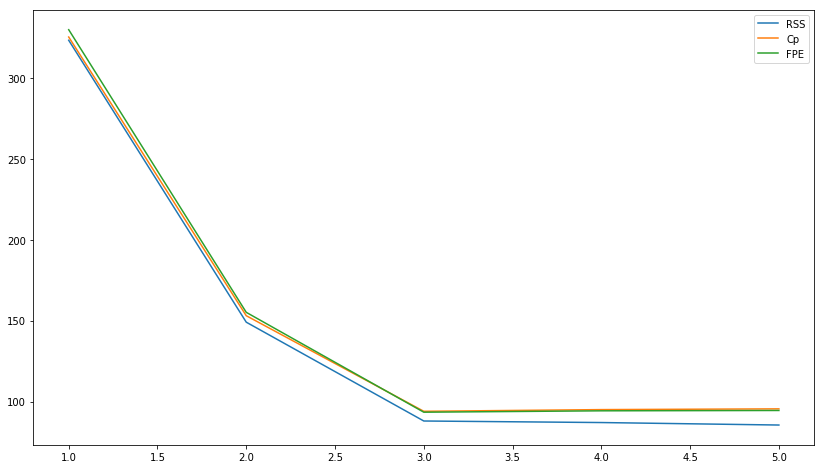

     s         RSS          Cp         FPE
0  1.0  323.388757  325.388757  329.921863
1  2.0  149.077156  153.077156  155.161938
2  3.0   87.974921   93.974921   93.416669
3  4.0   87.023120   95.023120   94.275046
4  5.0   85.483887   95.483887   94.482191
s* by Cp:  3
s* by FPE: 3



In [145]:
for i, n in enumerate(config.n_grid): 
    for j, sigma in enumerate(config.sigma_grid):
        config.recompile(n, sigma)
        print('--------------------------------------------------------------')
        print('\t\t\tSAMPLE #{}'.format(i * len(config.n_grid) + j + 1))
        print('--------------------------------------------------------------')
        print('\t\tCONFUGURATIONS & DATA')
        config.show()
        print('\n\t\tRLSM ITERATIONS')
        theta_pred, _, _, df = RMNK(config.X, config.y, s=config.s,
                                    verbose=True, create_dataframe=True)
#         print('===============================================')
        print('\n\t\t\tRESULTS')
        print('\nPARAMETERS')
        print('True values:\tθ: {}'.format(config.theta))
        print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
        plt.plot(df['s'], df['RSS'], label='RSS')
        plt.plot(df['s'], df['Cp'], label='Cp')
        plt.plot(df['s'], df['FPE'], label='FPE')
        plt.legend()
        plt.show()
        print(df)
        print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
        print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
        print()